Epoch 1, Train Loss: 0.520192, Train Acc: 0.828167, Test Loss: 0.593030, Test Acc: 0.810400
Epoch 2, Train Loss: 0.432095, Train Acc: 0.846650, Test Loss: 0.511614, Test Acc: 0.826800
Epoch 3, Train Loss: 0.403824, Train Acc: 0.854550, Test Loss: 0.490108, Test Acc: 0.833500
Epoch 4, Train Loss: 0.386043, Train Acc: 0.860367, Test Loss: 0.482200, Test Acc: 0.838100
Epoch 5, Train Loss: 0.358938, Train Acc: 0.868383, Test Loss: 0.458395, Test Acc: 0.842000
Epoch 6, Train Loss: 0.349240, Train Acc: 0.873233, Test Loss: 0.459836, Test Acc: 0.842700
Epoch 7, Train Loss: 0.329180, Train Acc: 0.879150, Test Loss: 0.439814, Test Acc: 0.849900
Epoch 8, Train Loss: 0.319808, Train Acc: 0.884133, Test Loss: 0.437309, Test Acc: 0.852000
Epoch 9, Train Loss: 0.308580, Train Acc: 0.887283, Test Loss: 0.426652, Test Acc: 0.854700
Epoch 10, Train Loss: 0.304867, Train Acc: 0.887650, Test Loss: 0.426036, Test Acc: 0.855200


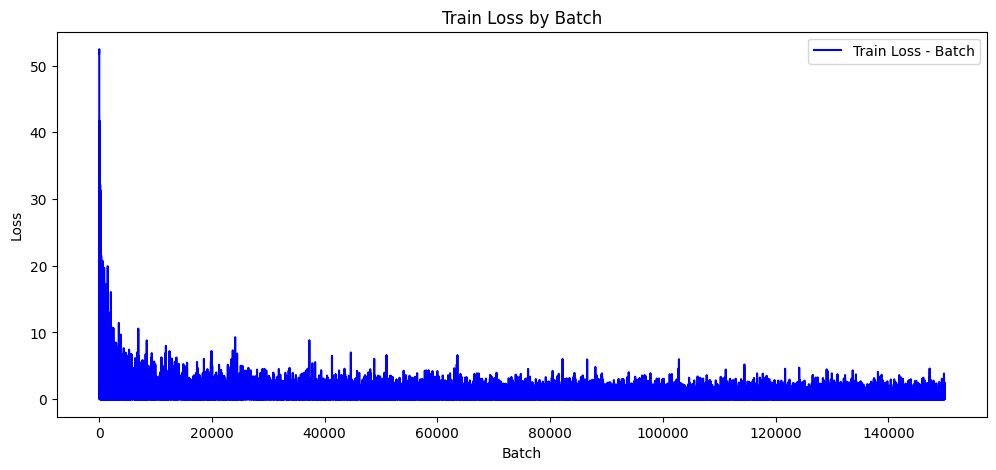

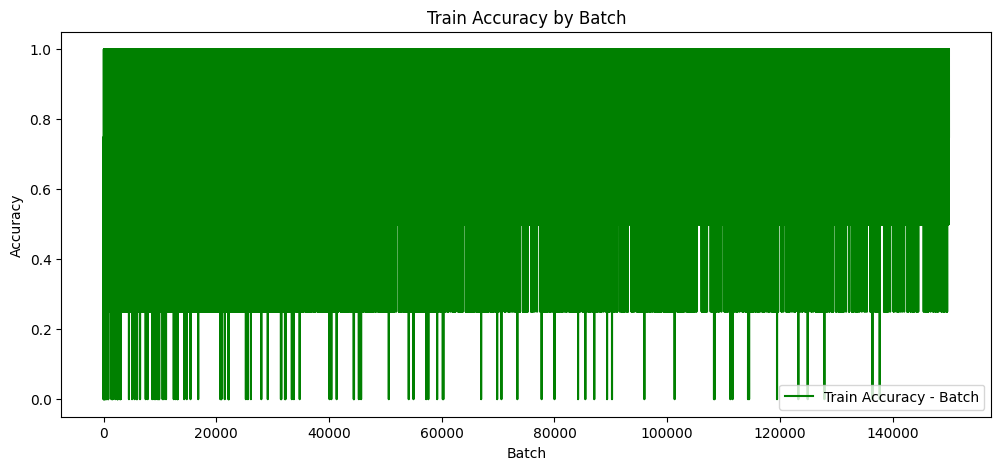

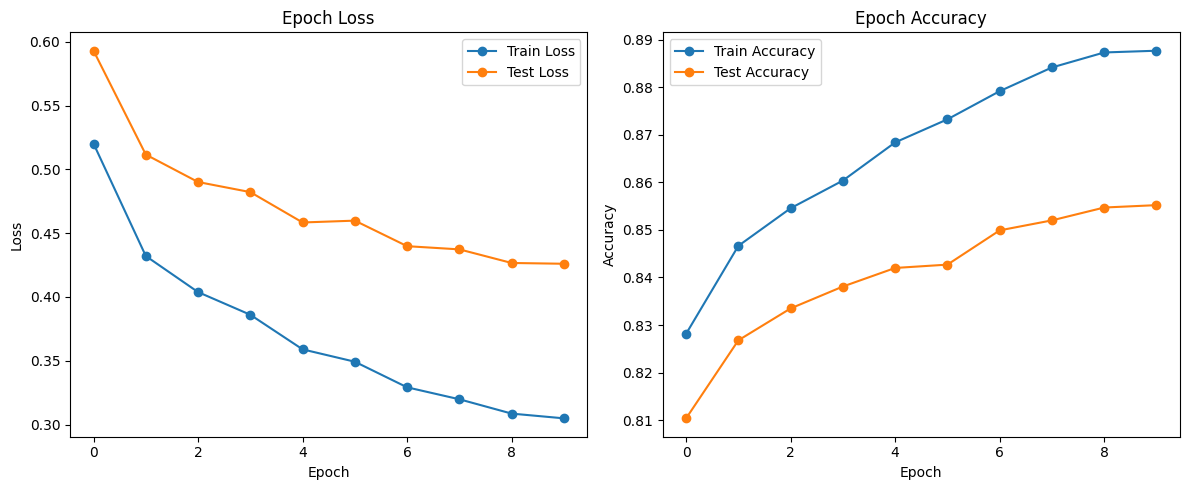

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import config
args = config.args


# 数据加载
trans = transforms.ToTensor()
mnist_train = datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)

num_inputs, num_outputs, num_hiddens = 784, 10, 256


train_iter = DataLoader(mnist_train, batch_size=args.batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=10000, shuffle=False, num_workers=0)

# 激活函数和softmax函数
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# 损失函数
def cross_entropy(y_hat, y):
    m = y_hat.shape[0]
    y_one_hot = np.eye(num_outputs)[y]
    return -np.sum(np.log(y_hat[range(m), y])) / m

# 前向传播
def model(X, w1, b1, w2, b2):
    H = relu(np.dot(X, w1) + b1)
    O = np.dot(H, w2) + b2
    return softmax(O), H

# 梯度计算
def calc_gradient(X, y, y_hat, H, w2):
    m = y.shape[0]
    y_one_hot = np.eye(num_outputs)[y]

    dO = (y_hat - y_one_hot) / m
    grad_w2 = np.dot(H.T, dO)
    grad_b2 = np.sum(dO, axis=0)

    dH = np.dot(dO, w2.T) * (H > 0).astype(float)
    grad_w1 = np.dot(X.T, dH)
    grad_b1 = np.sum(dH, axis=0)

    return grad_w1, grad_b1, grad_w2, grad_b2

# 参数更新
def update_params(params, grads, lr):
    for param, grad in zip(params, grads):
        param -= lr * grad

# 参数初始化
w1 = np.random.randn(num_inputs, num_hiddens) * 0.5
b1 = np.zeros(num_hiddens)
w2 = np.random.randn(num_hiddens, num_outputs) * 0.5
b2 = np.zeros(num_outputs)
params = [w1, b1, w2, b2]

# Metrics storage
batch_metrics = {
    'train_losses': [], 
    'train_accs': [], 
    'test_losses': [], 
    'test_accs': []
}
epoch_metrics = {
    'train_losses': [], 
    'train_accs': [], 
    'test_losses': [], 
    'test_accs': []
}
def accuracy(loader, w1, b1, w2, b2):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    # 设置数据加载器加载的是numpy数组而非torch.Tensor
    for images, labels in loader:
        X = images.view(-1, num_inputs).numpy()  # 转换为适当的形状和类型
        y = labels.numpy()
        
        # 前向传播
        y_hat, _ = model(X, w1, b1, w2, b2)
        
        # 计算损失
        loss = cross_entropy(y_hat, y)
        total_loss += loss * len(y)  # 累计总损失
        total_correct += (np.argmax(y_hat, axis=1) == y).sum()  # 计算正确预测的数量
        total_samples += len(y)
    
    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss, accuracy

# Training and evaluation loop

for epoch in range(args.epochs):
    for images, labels in train_iter:
        X = images.view(-1, num_inputs).numpy()
        y = labels.numpy()
        y_hat, H = model(X, *params)
        loss = cross_entropy(y_hat, y)
        grads = calc_gradient(X, y, y_hat, H, w2)
        update_params(params, grads, lr=args.lr)

        batch_metrics['train_losses'].append(loss)
        batch_acc = (np.argmax(y_hat, axis=1) == y).mean()
        batch_metrics['train_accs'].append(batch_acc)

    # Evaluate at the end of each epoch
    epoch_train_loss, epoch_train_acc = accuracy(train_iter, *params)
    epoch_test_loss, epoch_test_acc = accuracy(test_iter, *params)

    epoch_metrics['train_losses'].append(epoch_train_loss)
    epoch_metrics['train_accs'].append(epoch_train_acc)
    epoch_metrics['test_losses'].append(epoch_test_loss)
    epoch_metrics['test_accs'].append(epoch_test_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.6f}, Train Acc: {epoch_train_acc:.6f}, Test Loss: {epoch_test_loss:.6f}, Test Acc: {epoch_test_acc:.6f}')




# 绘制训练和测试损失与准确率的曲线图


# 绘制训练损失的曲线图
plt.figure(figsize=(12, 5))
plt.plot(batch_metrics['train_losses'], label='Train Loss - Batch', color='blue')
plt.title('Train Loss by Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 绘制训练准确率的曲线图
plt.figure(figsize=(12, 5))
plt.plot(batch_metrics['train_accs'], label='Train Accuracy - Batch', color='green')
plt.title('Train Accuracy by Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 绘制训练和测试损失的曲线图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_metrics['train_losses'], label='Train Loss', marker='o')
plt.plot(epoch_metrics['test_losses'], label='Test Loss', marker='o')
plt.title('Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练和测试准确率的曲线图
plt.subplot(1, 2, 2)
plt.plot(epoch_metrics['train_accs'], label='Train Accuracy', marker='o')
plt.plot(epoch_metrics['test_accs'], label='Test Accuracy', marker='o')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()